In [2]:
# 
# This is an implementation of the markov model in discrete time
# Pls consult the lecture notes for details
# 

import numpy as np
import matplotlib.pyplot as plt

class Markov:
    def __init__(self):
        # Attributes of the Markov Model
        self.iNrStates = None # 1. Number of states
        self.iMaxTime  = None    
        self.dPij = [] # 2. Transition Probability Pij[t][i,j]
        self.dPre = [] # 3.1 Prenumerando Benefits dPre[t][i]
        self.dPost= [] # 3.2 Postnumerando benefits dPost[t][i,j]
        self.dv   = [] # 4. Discount Rate dv[t]
        #Output
        self.dDK  = [] # This is the resulting Mathematical reserve per state V[t][i]
        self.dCF  = [] # This is the resultuing Cash Flow per state E[CF[t]|X_t0=j]
        #Maintenace
        self.bCalculated = False
        self.bCFCalculated = False
        #Start (120) --> Stop Time (50) 
        self.iStart = None
        self.iStop  = None
    
    def vDefineModel(self,iNrStates,iMaxTime=1200): # Here we define the structure of the model
        self.iNrStates = iNrStates
        self.iMaxTime = iMaxTime
        # The main task is to prepare the vectors (in time) of the objects which
        # are either vectors or matrices
        # Struture follows alway (as an example)
        # pdPij[time][stateFrom, StateTo]
        # The following does the trick - note MaxTime is to have these structures semistatic
        for i in range(iMaxTime):
            tempPij = np.zeros([iNrStates,iNrStates])
            tempPost = np.zeros([iNrStates,iNrStates])
            tempPre = np.zeros([iNrStates])
            tempDK = np.zeros([iNrStates])
            tempCF = np.zeros([iNrStates])
            self.dPij.append(tempPij)
            self.dPost.append(tempPost)
            self.dPre.append(tempPre)
            self.dDK.append(tempDK)
            self.dCF.append(tempCF)         
        tempv = np.zeros([iMaxTime])
        self.dv=tempv
    # What comes now is the functions mapping from outside into the internal parts
    # of the object
    
    def vSetDiscount(self,fIRate): # Defines Disount rates (here time independent)
        vTemp = 1./(1.+fIRate)
        print("Discount %.4f"%(vTemp))
        for i in range(self.iMaxTime):
            self.dv[i] = vTemp
        #Maintence
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPij(self,t,i,j,fValue): # Transition Probabilities
        self.dPij[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPre(self,t,i,j,fValue): # Preumerando Benefits
        self.dPre[t][i] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPost(self,t,i,j,fValue): # Post Nummerando Benefits
        self.dPost[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    # Now we do the calculations
    #  First the mathematical reserves ...
    # Thiele Difference Equation
    def doCalculateDK(self,iStart,iStop,iAge,iState):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculated = True
        for i in range(self.iMaxTime):
            self.dDK[i] *= 0.
        # the following block implements the Thiele Backwards recursion (START)
        for i in range(self.iStart-1, self.iStop-1,-1):
            #print("Calc Time", i)
            for j in range(self.iNrStates):
                self.dDK[i][j] = self.dPre[i][j]
                for k in range(self.iNrStates):
                    self.dDK[i][j] += self.dv[i]*self.dPij[i][j,k]*(self.dPost[i][j,k]+self.dDK[i+1][k])
        # (END)
        
        
    # ... then the cash flows
    
    def doCalculateCF(self,iStart,iStop,iAge,iState,bTrace=False):
        self.iStop = iStop
        self.iStart = iStart
        self.bCFCalculated = True
        for i in range(self.iMaxTime):
            self.dCF[i] *= 0.
        
        CurrentP = np.mat(np.identity(self.iNrStates))
        if bTrace:
            print("----- ----- ----- ----- ")
        for i in range(self.iStop, self.iStart):
            if bTrace:
                print("----- ----- ----- ----- ")
                print(" Time ", i)
                print("CF BoP", self.dCF[i])
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    self.dCF[i][k] += CurrentP[k,l] * self.dPre[i][l]
            if bTrace:
                print("CF BoP after Pre", self.dCF[i])
            NextP = np.mat(self.dPij[i])
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
                print("Next P\n", NextP) 
                print("+++++ +++++ +++++ ")
                
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    for m in range(self.iNrStates):
                        self.dCF[i+1][k] += CurrentP[k,l] * NextP[l,m] * self.dPost[i][l,m]
            if bTrace:
                print("CF EoP t", self.dCF[i])
                print("CF EoP t+1", self.dCF[i+1])
                                        # Start P(s,s) = identity Matrix
            CurrentP = CurrentP * NextP # Chapman Kolmorgorov P(s,t) = P(s,t-1) * P(t-1,t)
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP EoP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
    
    # The following are the functions returing the internal results towards
    # the external world

    
    def dGetDK(self,iStart,iStop,iAge,iState):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculated)):
            self.doCalculateDK(iStart,iStop,iAge,iState)
        return(self.dDK[iAge][iState])

    def dGetCF(self,iStart,iStop,iAge,iState):
        if (not(self.bCFCalculated) or self.iStart != iStart or self.iStop != iStop ):
            self.doCalculateCF(iStart,iStop,iAge,iState)
        return(self.dCF[iAge][iState])
    
    # The following three are 'comfort functions' to show how the model works
    
    def PrintDKs(self,iStart,iStop):
        for i in range(iStop,iStart+1):
            strTemp = " %3d :"%(i)
            for j in range(self.iNrStates):
                 strTemp += "   %10.4f  "%(self.dGetDK(iStart,iStop,i,j))
            print(strTemp)
    
    def PlotDKs(self,iStart,iStop,figNr=1):
        x = []
        y = []
        for i in range(iStop,iStart+1):
            x.append(i)
            ytemp = np.zeros(self.iNrStates)
            for j in range(self.iNrStates):
                ytemp[j] = self.dGetDK(iStart,iStop,i,j)
            y.append(ytemp)
        plt.figure(figNr)
        plt.plot(x,y)
        plt.grid(True)
        
    def PlotCFs(self,iStart,iStop,figNr=2):
        x = []
        y = []
        for i in range(iStop,iStart+1):
            x.append(i)
            ytemp = np.zeros(self.iNrStates)
            for j in range(self.iNrStates):
                ytemp[j] = self.dGetCF(iStart,iStop,i,j)
            y.append(ytemp)
        plt.figure(figNr)
        plt.plot(x,y)
        plt.grid(True)

In [86]:
def Qx(gender,x,t,param =[]):
    # This is our default mortality
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    dTemp = min(1,max(0,np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t)))
    if x > 116: return(1)
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

In [125]:
class ATWPlus:
    def __init__(self,Qx=Qx,iOmega=114,i=0.02):
        self.iOmega = iOmega
        self.dv = 1/(1+i)
        self.iRate = i
        self.Qx = Qx
        self.psymMBenefitsR = Markov()
        self.psymMBenefitsR.vDefineModel(2)
        self.psymMBenefitsD1 = Markov()
        self.psymMBenefitsD1.vDefineModel(2)
        self.psymMBenefitsD2 = Markov()
        self.psymMBenefitsD2.vDefineModel(2)
        self.psymMPremium = Markov()
        self.psymMPremium.vDefineModel(2)
        self.psymMR = Markov()
        self.psymMR.vDefineModel(2)
        self.MyObjects = [self.psymMBenefitsR,self.psymMBenefitsD1,self.psymMBenefitsD2,self.psymMPremium,self.psymMR]
        self.bPremiumCalculated = False
        self.dEps = 1.e-8

    def vSetMaxRGW(self, nYears):
        self.nYears = nYears

    def dCalcPremium(self,iX0=30, iS=65, iGender = 0):
        self.iX0 = iX0
        self.iS = iS
        self.iGender =iGender
        # Define States --> done above
        
        # Define Probabilities
        for iLocAge in range(self.iX0,self.iOmega):
            # * -> * and * -> t
            qx = self.Qx(self.iGender,iLocAge,2024)
            px = 1- qx
            self.psymMBenefitsR.vSetPij(iLocAge,0,0,px)
            self.psymMBenefitsR.vSetPij(iLocAge,0,1,qx)
            self.psymMBenefitsD1.vSetPij(iLocAge,0,0,px)
            self.psymMBenefitsD1.vSetPij(iLocAge,0,1,qx)
            self.psymMBenefitsD2.vSetPij(iLocAge,0,0,px)
            self.psymMBenefitsD2.vSetPij(iLocAge,0,1,qx)
            self.psymMPremium.vSetPij(iLocAge,0,0,px)
            self.psymMR.vSetPij(iLocAge,0,1,qx)
            self.psymMR.vSetPij(iLocAge,0,0,px)

        
        # Define Discount
        self.psymMBenefitsR.vSetDiscount(self.iRate)
        self.psymMBenefitsD1.vSetDiscount(self.iRate)
        self.psymMBenefitsD2.vSetDiscount(self.iRate)
        self.psymMPremium.vSetDiscount(self.iRate)
        self.psymMR.vSetDiscount(self.iRate)
        # Define Benefits
        # Premium (1)
        for iLocAge in range(self.iX0,self.iS):
            self.psymMPremium.vSetPre(iLocAge,0,0,1)
        # Annity in Payment
        for iLocAge in range(self.iS,self.iOmega):
            self.psymMBenefitsR.vSetPre(iLocAge,0,0,1)

        # Death Benefit after Maturity assume Annuity 1 and duration
        print("TBD")
        
        print("Equivalence: P x axm = naex + P IAan + P mDAx" )
        print("Equivalence: P  = naex/(axm - IAan - mDAx)\n" )

        iAge = self.iX0
        iState = 0 # aliove *
        dOldP = 0
        for i in range(15):
        
            dPVBenefitsR = self.psymMBenefitsR.dGetDK(self.iOmega,self.iX0,iAge,iState)
            dPVBenefitsD1 = self.psymMBenefitsD1.dGetDK(self.iOmega,self.iX0,iAge,iState)
            dPVBenefitsD2 = self.psymMBenefitsD2.dGetDK(self.iOmega,self.iX0,iAge,iState)
            dPVPremium = self.psymMPremium.dGetDK(self.iOmega,self.iX0,iAge,iState)

            dPremium = dPVBenefitsR / (dPVPremium - dPVBenefitsD1 - dPVBenefitsD2)
            if abs(dPremium-dOldP) < self.dEps: 
                print("Nr Iterations %d for Epsilon %8.2e"%(i,self.dEps))
                break
            dOldP = dPremium
            print(dPVBenefitsR,dPVPremium,dPremium)

            for iLocAge in range(self.iS,self.iS+self.nYears):
                # (!)Corretion needed 1/dPrem given the above Furmula
                dDeathBenefit = (self.iS-self.iX0)  - (iLocAge - self.iS + 1) / dPremium
                if dDeathBenefit < 0: dDeathBenefit = 0
                self.psymMBenefitsD2.vSetPost(iLocAge,0,1,dDeathBenefit)

                # Death Benefit Before Maturity Assume P=1
            for iLocAge in range(self.iX0,self.iS):
                self.psymMBenefitsD1.vSetPost(iLocAge,0,1,1+(iLocAge-self.iX0))
        
        self.dPremium = dPremium
        self.bPremiumCalculated = True
        return("--> Premium %10.7f"%(dPremium))

    def PrintMR(self):
        if not self.bPremiumCalculated: dTemp=self.dCalcPremium()
        # Adjust Benefit Levels
        for iLocAge in range(self.iX0,self.iS):
            self.psymMBenefitsD1.vSetPost(iLocAge,0,1,(1+(iLocAge-self.iX0))*self.dPremium)
        #Populate MR Module
        # Premium (1)
        for iLocAge in range(self.iX0,self.iS):
            self.psymMR.vSetPre(iLocAge,0,0,-self.dPremium)
        # Annity in Payment
        for iLocAge in range(self.iS,self.iOmega):
            self.psymMR.vSetPre(iLocAge,0,0,1)
        #Death Benefit Before           
        for iLocAge in range(self.iS,self.iS+self.nYears):
            dDeathBenefit = (self.iS-self.iX0) * self.dPremium - (iLocAge - self.iS + 1)
            if dDeathBenefit < 0: dDeathBenefit = 0
            self.psymMR.vSetPost(iLocAge,0,1,dDeathBenefit)

        # Death Benefit Before Maturity 
        for iLocAge in range(self.iX0,self.iS):
            self.psymMR.vSetPost(iLocAge,0,1,(1+(iLocAge-self.iX0))*self.dPremium)

        self.psymMR.PrintDKs(self.iOmega,self.iX0)
        self.psymMR.PlotDKs(self.iOmega,self.iX0)

        iNr = 2
        for i in self.MyObjects:
            i.PlotCFs(self.iOmega,self.iX0,figNr=iNr)
            iNr +=1





        
        
        

   


Discount 0.9804
Discount 0.9804
Discount 0.9804
Discount 0.9804
Discount 0.9804
TBD
Equivalence: P x axm = naex + P IAan + P mDAx
Equivalence: P  = naex/(axm - IAan - mDAx)

7.469364660769151 24.982342985478564 0.298985754262955
7.469364660769151 24.982342985478564 0.33038423921926924
7.469364660769151 24.982342985478564 0.3323618857962381
7.469364660769151 24.982342985478564 0.3324874682922371
7.469364660769151 24.982342985478564 0.33249539564164565
7.469364660769151 24.982342985478564 0.33249589586443973
7.469364660769151 24.982342985478564 0.33249592742819306
Nr Iterations 7 for Epsilon 1.00e-08
--> Premium  0.3324959
  30 :       0.0000         0.0000  
  31 :       0.3391         0.0000  
  32 :       0.6851         0.0000  
  33 :       1.0380         0.0000  
  34 :       1.3979         0.0000  
  35 :       1.7651         0.0000  
  36 :       2.1396         0.0000  
  37 :       2.5217         0.0000  
  38 :       2.9114         0.0000  
  39 :       3.3091         0.0000  
 

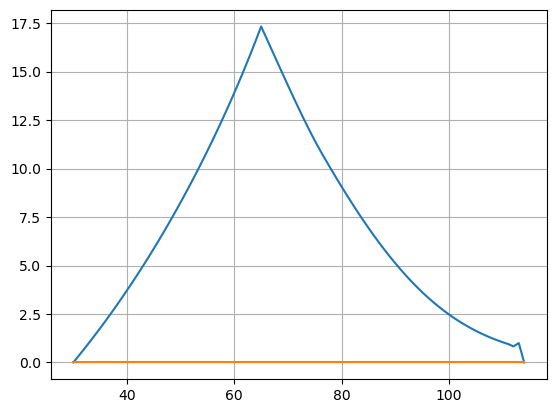

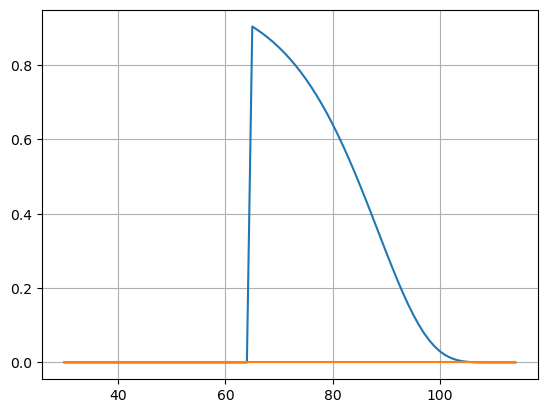

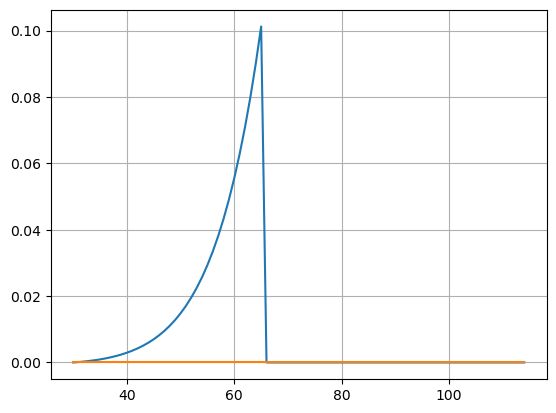

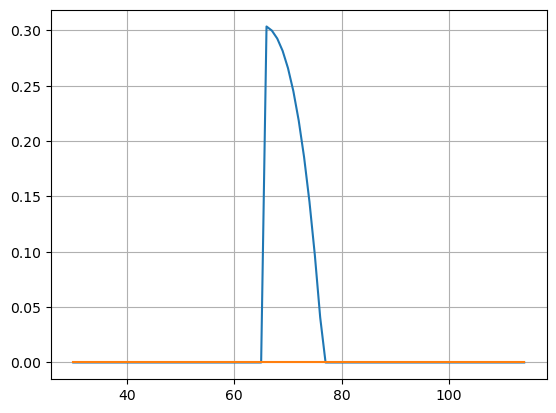

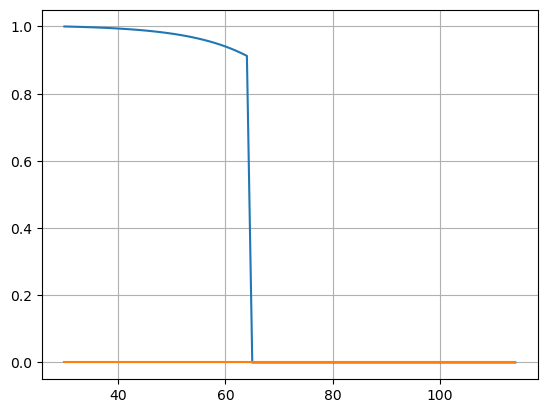

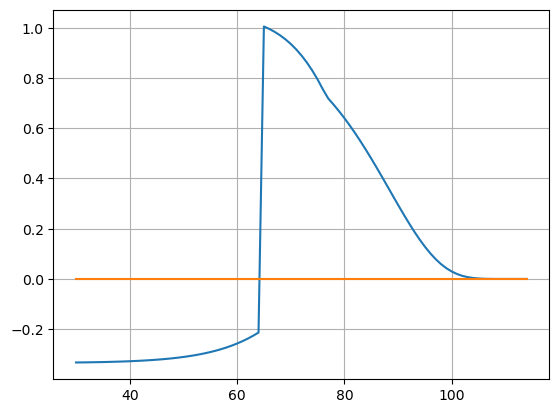

In [131]:
a = ATWPlus()
a.vSetMaxRGW(20)
print(a.dCalcPremium())
a.PrintMR()